<a href="https://colab.research.google.com/github/adenurchalisa/Automatic-Photo-Clustering-System-Optimization-HDBSCAN/blob/main/notebooks/5_Granular_Hyperparameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Granular Hyperparameter**

In [ ]:
print("🔍 Checking CUDA version...")
!nvcc --version | grep "release"

print("\n⏳ Installing RAPIDS cuML (GPU-accelerated ML)...")
print("   This may take 2-5 minutes...\n")
!pip install --extra-index-url=https://pypi.nvidia.com cudf-cu12 cuml-cu12 -q

print("\n✅ Verifying installation...")
try:
    import cuml
    from cuml.cluster import HDBSCAN as cuHDBSCAN
    print(f"   cuML version: {cuml.__version__}")
    print("   GPU HDBSCAN: Ready ✅")
except ImportError as e:
    print(f"   ❌ Error: {e}")
    print("   Please restart runtime and try again.")

print("\n" + "="*60)
print("✅ Installation complete!")
print("="*60)

🔍 Checking CUDA version...
Cuda compilation tools, release 12.8, V12.8.93

⏳ Installing RAPIDS cuML (GPU-accelerated ML)...
   This may take 2-5 minutes...

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 210.8 MB/s eta 0:00:00

✅ Verifying installation...
   cuML version: 26.02.000
   GPU HDBSCAN: Ready ✅

✅ Installation complete!


In [ ]:
from IPython.core.debugger import os
import numpy as np
import pickle
import time
import os
import warnings
from collections import Counter
from datetime import datetime

warnings.filterwarnings('ignore')

import cupy as cp
from cuml.cluster import HDBSCAN as cuHDBSCAN

from sklearn.metrics import silhouette_score, davies_bouldin_score

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

class Config:
    """Central configuration for experiment parameters."""

    # Paths (Note: S.Kom with capital K)
    EMBEDDINGS_PATH = '/content/drive/MyDrive/OTW S.KOM/Embeddings/embeddings_data.pkl'
    RESULTS_DIR = '/content/drive/MyDrive/OTW S.KOM/Results/'
    PLOTS_DIR = '/content/drive/MyDrive/OTW S.KOM/Results/Plots/'

    # Granular Parameter Grid
    PARAM_GRID = {
        'min_cluster_size': [5, 7, 8, 10, 12, 14, 15, 16, 18, 20],
        'min_samples': [1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 15],
        'cluster_selection_method': ['eom', 'leaf']
    }

# Print configuration
print("="*60)
print("📦 LIBRARIES IMPORTED")
print("="*60)
print(f"   NumPy  : {np.__version__}")
print(f"   CuPy   : {cp.__version__}")
import cuml; print(f"   cuML   : {cuml.__version__}")

print("\n" + "="*60)
print("⚙️ CONFIGURATION")
print("="*60)
grid = Config.PARAM_GRID
total_combinations = len(grid['min_cluster_size']) * len(grid['min_samples']) * len(grid['cluster_selection_method'])
print(f"   min_cluster_size : {grid['min_cluster_size']}")
print(f"   min_samples      : {grid['min_samples']}")
print(f"   methods          : {grid['cluster_selection_method']}")
print(f"   Total combinations: {total_combinations}")

print("\n" + "="*60)
print("✅ Setup complete!")
print("="*60)

📦 LIBRARIES IMPORTED
   NumPy  : 2.0.2
   CuPy   : 14.0.1
   cuML   : 26.02.000

⚙️ CONFIGURATION
   min_cluster_size : [5, 7, 8, 10, 12, 14, 15, 16, 18, 20]
   min_samples      : [1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 15]
   methods          : ['eom', 'leaf']
   Total combinations: 220

✅ Setup complete!


In [ ]:
from google.colab import drive

print("="*60)
print("📁 MOUNT DRIVE & LOAD DATA")
print("="*60)

# Mount Google Drive
if os.path.exists('/content/drive/MyDrive'):
    print("\n✅ Google Drive sudah ter-mount!")
else:
    drive.mount('/content/drive')
    print("\n✅ Google Drive mounted!")

# Create output directories
os.makedirs(Config.RESULTS_DIR, exist_ok=True)
os.makedirs(Config.PLOTS_DIR, exist_ok=True)

# Load embeddings
print(f"\n⏳ Loading embeddings...")
print(f"   Path: {Config.EMBEDDINGS_PATH}")

with open(Config.EMBEDDINGS_PATH, 'rb') as f:
    data = pickle.load(f)

embeddings = np.array(data['embeddings']).astype('float32')
metadata = data['metadata']

print(f"\n✅ Data loaded!")
print(f"   Shape    : {embeddings.shape}")
print(f"   Metadata : {len(metadata)} items")
print(f"   Memory   : {embeddings.nbytes / 1024 / 1024:.2f} MB")

# Transfer to GPU
print(f"\n⏳ Transferring to GPU...")
embeddings_gpu = cp.asarray(embeddings)
print(f"✅ Data on GPU!")

# Quick dataset summary
image_paths = [m['image_path'] for m in metadata]
unique_images = len(set(image_paths))
faces_per_image = Counter(image_paths)
single_face = len([p for p, c in faces_per_image.items() if c == 1])

print(f"\n📊 Dataset Summary:")
print(f"   Unique photos    : {unique_images:,}")
print(f"   Total embeddings : {len(embeddings):,}")
print(f"   Avg faces/photo  : {len(embeddings)/unique_images:.1f}")
print(f"   Single-face photos: {single_face} ({single_face/unique_images:.1%})")

print("\n" + "="*60)

📁 MOUNT DRIVE & LOAD DATA

✅ Google Drive sudah ter-mount!

⏳ Loading embeddings...
   Path: /content/drive/MyDrive/OTW S.KOM/Embeddings/embeddings_data.pkl

✅ Data loaded!
   Shape    : (12715, 512)
   Metadata : 12715 items
   Memory   : 24.83 MB

⏳ Transferring to GPU...
✅ Data on GPU!

📊 Dataset Summary:
   Unique photos    : 2,365
   Total embeddings : 12,715
   Avg faces/photo  : 5.4
   Single-face photos: 605 (25.6%)



In [ ]:
def run_granular_tuning(embeddings_gpu, embeddings_cpu, param_grid):
    mcs_values = param_grid['min_cluster_size']
    ms_values = param_grid['min_samples']
    methods = param_grid['cluster_selection_method']

    total = len(mcs_values) * len(ms_values) * len(methods)

    print("="*70)
    print("🔧 GRANULAR HYPERPARAMETER TUNING")
    print("="*70)
    print(f"\n📋 Parameter Grid:")
    print(f"   min_cluster_size: {mcs_values}")
    print(f"   min_samples: {ms_values}")
    print(f"   methods: {methods}")
    print(f"   Total: {total} combinations")

    results = []
    start_time = time.time()

    # Track best results
    best_sil = {'score': 0, 'config': None}
    best_bal = {'score': 0, 'config': None}
    best_noise = {'noise': 1.0, 'config': None}

    print(f"\n{'#':<5} {'mcs':<5} {'ms':<5} {'meth':<5} {'Clust':<7} {'Noise%':<8} {'Silhou':<9} {'Balanced':<9} {'Note':<8}")
    print("-"*75)

    iteration = 0
    for mcs in mcs_values:
        for ms in ms_values:
            for method in methods:
                iteration += 1

                try:
                    # Run GPU HDBSCAN
                    clusterer = cuHDBSCAN(
                        min_cluster_size=mcs,
                        min_samples=ms,
                        cluster_selection_method=method,
                        metric='euclidean',
                        output_type='numpy'
                    )
                    labels = clusterer.fit_predict(embeddings_gpu)

                    if isinstance(labels, cp.ndarray):
                        labels = cp.asnumpy(labels)

                    # Analyze results
                    cluster_counts = Counter(labels)
                    n_clusters = len([k for k in cluster_counts.keys() if k != -1])
                    n_noise = cluster_counts.get(-1, 0)
                    noise_ratio = n_noise / len(labels)

                    # Evaluate
                    mask = labels != -1
                    if mask.sum() > 0 and len(np.unique(labels[mask])) >= 2:
                        silhouette = silhouette_score(embeddings_cpu[mask], labels[mask])
                        dbi = davies_bouldin_score(embeddings_cpu[mask], labels[mask])
                    else:
                        silhouette = -1.0
                        dbi = float('inf')

                except Exception as e:
                    n_clusters = 0
                    n_noise = len(embeddings_cpu)
                    noise_ratio = 1.0
                    silhouette = -1.0
                    dbi = float('inf')
                    labels = np.array([-1] * len(embeddings_cpu))
                    cluster_counts = Counter(labels)

                # Calculate balanced score
                balanced_score = silhouette * (1 - noise_ratio) if silhouette > 0 else -1

                # Store result
                results.append({
                    'min_cluster_size': mcs,
                    'min_samples': ms,
                    'cluster_selection_method': method,
                    'n_clusters': n_clusters,
                    'n_noise': n_noise,
                    'noise_ratio': noise_ratio,
                    'silhouette': silhouette,
                    'dbi': dbi,
                    'balanced_score': balanced_score,
                    'labels': labels,
                    'cluster_counts': cluster_counts
                })

                # Track best results
                note = ""
                if silhouette > best_sil['score']:
                    best_sil = {'score': silhouette, 'config': (mcs, ms, method)}
                    note = "⭐Sil"
                if balanced_score > best_bal['score']:
                    best_bal = {'score': balanced_score, 'config': (mcs, ms, method)}
                    note = note + "+Bal" if note else "⭐Bal"
                if noise_ratio < best_noise['noise'] and silhouette > 0.20:
                    best_noise = {'noise': noise_ratio, 'config': (mcs, ms, method)}
                    if "⭐" not in note:
                        note = "⭐Noise"

                # Print progress
                if note or iteration % 30 == 0:
                    m_short = method[:3]
                    print(f"{iteration:<5} {mcs:<5} {ms:<5} {m_short:<5} {n_clusters:<7} {noise_ratio:<8.1%} {silhouette:<9.4f} {balanced_score:<9.4f} {note:<8}")

    total_time = time.time() - start_time
    print("-"*75)
    print(f"\n✅ Completed in {total_time:.1f}s ({total_time/60:.1f} min)")
    print(f"\n🏆 Best Silhouette: {best_sil['score']:.4f} at {best_sil['config']}")
    print(f"⚖️ Best Balanced: {best_bal['score']:.4f} at {best_bal['config']}")
    print(f"📉 Lowest Noise: {best_noise['noise']:.1%} at {best_noise['config']}")

    return results


In [ ]:
def analyze_results(results):
    print(f"\n{'='*70}")
    print("📊 COMPREHENSIVE ANALYSIS")
    print(f"{'='*70}")

    # Filter valid results
    valid = [r for r in results if r['silhouette'] > 0]
    print(f"\n   Valid configurations: {len(valid)}/{len(results)}")

    # =========================================================================
    # 1. TOP 10 by Silhouette
    # =========================================================================
    print(f"\n🏆 TOP 10 BY SILHOUETTE SCORE:")
    sorted_by_sil = sorted(valid, key=lambda x: x['silhouette'], reverse=True)[:10]

    print(f"   {'#':<4} {'mcs':<5} {'ms':<5} {'meth':<5} {'Clust':<7} {'Noise%':<8} {'Silhou':<9} {'DBI':<9}")
    print("   " + "-"*55)
    for i, r in enumerate(sorted_by_sil):
        m = r['cluster_selection_method'][:3]
        print(f"   {i+1:<4} {r['min_cluster_size']:<5} {r['min_samples']:<5} {m:<5} {r['n_clusters']:<7} {r['noise_ratio']:<8.1%} {r['silhouette']:<9.4f} {r['dbi']:<9.4f}")

    # =========================================================================
    # 2. TOP 10 by Balanced Score
    # =========================================================================
    print(f"\n⚖️ TOP 10 BY BALANCED SCORE (Silhouette × (1 - Noise)):")
    sorted_by_bal = sorted(valid, key=lambda x: x['balanced_score'], reverse=True)[:10]

    print(f"   {'#':<4} {'mcs':<5} {'ms':<5} {'meth':<5} {'Clust':<7} {'Noise%':<8} {'Silhou':<9} {'Balanced':<9}")
    print("   " + "-"*60)
    for i, r in enumerate(sorted_by_bal):
        m = r['cluster_selection_method'][:3]
        print(f"   {i+1:<4} {r['min_cluster_size']:<5} {r['min_samples']:<5} {m:<5} {r['n_clusters']:<7} {r['noise_ratio']:<8.1%} {r['silhouette']:<9.4f} {r['balanced_score']:<9.4f}")

    # =========================================================================
    # 3. TOP 10 by Lowest Noise (with Silhouette > 0.25)
    # =========================================================================
    print(f"\n📉 TOP 10 BY LOWEST NOISE (with Silhouette > 0.25):")
    acceptable = [r for r in valid if r['silhouette'] > 0.25]
    sorted_by_noise = sorted(acceptable, key=lambda x: x['noise_ratio'])[:10]

    print(f"   {'#':<4} {'mcs':<5} {'ms':<5} {'meth':<5} {'Clust':<7} {'Noise%':<8} {'Silhou':<9} {'DBI':<9}")
    print("   " + "-"*55)
    for i, r in enumerate(sorted_by_noise):
        m = r['cluster_selection_method'][:3]
        print(f"   {i+1:<4} {r['min_cluster_size']:<5} {r['min_samples']:<5} {m:<5} {r['n_clusters']:<7} {r['noise_ratio']:<8.1%} {r['silhouette']:<9.4f} {r['dbi']:<9.4f}")

    # =========================================================================
    # 4. Pareto Optimal Configurations
    # =========================================================================
    print(f"\n🎯 PARETO OPTIMAL CONFIGURATIONS:")
    print(f"   (No other config is better in BOTH Silhouette AND Noise)")

    pareto = []
    for r in valid:
        is_dominated = False
        for other in valid:
            if other == r:
                continue
            if (other['silhouette'] >= r['silhouette'] and
                other['noise_ratio'] <= r['noise_ratio']):
                if (other['silhouette'] > r['silhouette'] or
                    other['noise_ratio'] < r['noise_ratio']):
                    is_dominated = True
                    break
        if not is_dominated:
            pareto.append(r)

    pareto = sorted(pareto, key=lambda x: x['silhouette'], reverse=True)[:15]

    print(f"\n   Found {len(pareto)} Pareto-optimal configurations:")
    print(f"   {'#':<4} {'mcs':<5} {'ms':<5} {'meth':<5} {'Clust':<7} {'Noise%':<8} {'Silhou':<9}")
    print("   " + "-"*50)
    for i, r in enumerate(pareto):
        m = r['cluster_selection_method'][:3]
        print(f"   {i+1:<4} {r['min_cluster_size']:<5} {r['min_samples']:<5} {m:<5} {r['n_clusters']:<7} {r['noise_ratio']:<8.1%} {r['silhouette']:<9.4f}")

    # =========================================================================
    # 5. Summary
    # =========================================================================
    best_sil = sorted_by_sil[0]
    best_bal = sorted_by_bal[0]
    best_noise = sorted_by_noise[0] if sorted_by_noise else None

    print(f"\n{'='*70}")
    print("📋 SUMMARY: BEST CONFIGURATIONS")
    print(f"{'='*70}")

    print(f"""
┌──────────────────────────────────────────────────────────────────────┐
│                    THREE PERSPECTIVES                                │
├──────────────────────────────────────────────────────────────────────┤
│                                                                      │
│  1️⃣  BEST SILHOUETTE (Cluster Quality):                              │
│      mcs={best_sil['min_cluster_size']}, ms={best_sil['min_samples']}, method={best_sil['cluster_selection_method']}                             │
│      Silhouette: {best_sil['silhouette']:.4f}, Noise: {best_sil['noise_ratio']:.1%}, Clusters: {best_sil['n_clusters']}                │
│                                                                      │
│  2️⃣  BEST BALANCED (Quality × Coverage):                             │
│      mcs={best_bal['min_cluster_size']}, ms={best_bal['min_samples']}, method={best_bal['cluster_selection_method']}                             │
│      Silhouette: {best_bal['silhouette']:.4f}, Noise: {best_bal['noise_ratio']:.1%}, Clusters: {best_bal['n_clusters']}                │
│      Balanced Score: {best_bal['balanced_score']:.4f}                                      │
│                                                                      │""")

    if best_noise:
        print(f"""│  3️⃣  LOWEST NOISE (Max Coverage, Sil > 0.25):                        │
│      mcs={best_noise['min_cluster_size']}, ms={best_noise['min_samples']}, method={best_noise['cluster_selection_method']}                             │
│      Silhouette: {best_noise['silhouette']:.4f}, Noise: {best_noise['noise_ratio']:.1%}, Clusters: {best_noise['n_clusters']}                │
│                                                                      │""")

    print("└──────────────────────────────────────────────────────────────────────┘")

    return {
        'best_silhouette': best_sil,
        'best_balanced': best_bal,
        'lowest_noise': best_noise,
        'pareto_optimal': pareto,
        'all_valid': valid
    }

In [ ]:
def visualize_results(results, best_configs, save_path=None):
    print(f"\n{'='*70}")
    print("📊 GENERATING VISUALIZATIONS")
    print(f"{'='*70}")

    valid = [r for r in results if r['silhouette'] > 0]

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # -------------------------------------------------------------------------
    # Plot 1: Silhouette vs Noise (Trade-off with Pareto Front)
    # -------------------------------------------------------------------------
    ax1 = axes[0, 0]

    # Scatter all points
    for method, color in [('eom', 'steelblue'), ('leaf', 'coral')]:
        method_results = [r for r in valid if r['cluster_selection_method'] == method]
        noises = [r['noise_ratio'] for r in method_results]
        sils = [r['silhouette'] for r in method_results]
        ax1.scatter(noises, sils, c=color, alpha=0.5, s=30, label=method.upper())

    # Highlight best configs
    ax1.scatter(best_configs['best_silhouette']['noise_ratio'],
               best_configs['best_silhouette']['silhouette'],
               color='red', s=250, marker='*', edgecolors='black', linewidths=1.5,
               label='Best Silhouette', zorder=5)

    ax1.scatter(best_configs['best_balanced']['noise_ratio'],
               best_configs['best_balanced']['silhouette'],
               color='lime', s=250, marker='*', edgecolors='black', linewidths=1.5,
               label='Best Balanced', zorder=5)

    if best_configs['lowest_noise']:
        ax1.scatter(best_configs['lowest_noise']['noise_ratio'],
                   best_configs['lowest_noise']['silhouette'],
                   color='yellow', s=250, marker='*', edgecolors='black', linewidths=1.5,
                   label='Lowest Noise', zorder=5)

    # Pareto front line
    pareto = sorted(best_configs['pareto_optimal'], key=lambda x: x['noise_ratio'])
    if pareto:
        pareto_noises = [r['noise_ratio'] for r in pareto]
        pareto_sils = [r['silhouette'] for r in pareto]
        ax1.plot(pareto_noises, pareto_sils, 'g--', linewidth=2, alpha=0.7, label='Pareto Front')

    ax1.set_xlabel('Noise Ratio (Lower = Better)', fontsize=10)
    ax1.set_ylabel('Silhouette Score (Higher = Better)', fontsize=10)
    ax1.set_title('Trade-off: Silhouette vs Noise', fontweight='bold')
    ax1.legend(loc='upper right', fontsize=8)
    ax1.grid(True, alpha=0.3)

    # -------------------------------------------------------------------------
    # Plot 2: Silhouette vs min_cluster_size
    # -------------------------------------------------------------------------
    ax2 = axes[0, 1]

    for method, color in [('eom', 'steelblue'), ('leaf', 'coral')]:
        method_results = [r for r in valid if r['cluster_selection_method'] == method]
        mcs_list = [r['min_cluster_size'] for r in method_results]
        sil_list = [r['silhouette'] for r in method_results]
        ax2.scatter(mcs_list, sil_list, c=color, alpha=0.5, label=method.upper(), s=30)

    ax2.set_xlabel('min_cluster_size', fontsize=10)
    ax2.set_ylabel('Silhouette Score', fontsize=10)
    ax2.set_title('Silhouette vs min_cluster_size', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # -------------------------------------------------------------------------
    # Plot 3: Silhouette vs min_samples
    # -------------------------------------------------------------------------
    ax3 = axes[0, 2]

    for method, color in [('eom', 'steelblue'), ('leaf', 'coral')]:
        method_results = [r for r in valid if r['cluster_selection_method'] == method]
        ms_list = [r['min_samples'] for r in method_results]
        sil_list = [r['silhouette'] for r in method_results]
        ax3.scatter(ms_list, sil_list, c=color, alpha=0.5, label=method.upper(), s=30)

    ax3.set_xlabel('min_samples', fontsize=10)
    ax3.set_ylabel('Silhouette Score', fontsize=10)
    ax3.set_title('Silhouette vs min_samples', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # -------------------------------------------------------------------------
    # Plot 4: Heatmap Silhouette (EOM)
    # -------------------------------------------------------------------------
    ax4 = axes[1, 0]

    eom_results = [r for r in valid if r['cluster_selection_method'] == 'eom']
    mcs_vals = sorted(set(r['min_cluster_size'] for r in eom_results))
    ms_vals = sorted(set(r['min_samples'] for r in eom_results))

    heatmap_sil = np.full((len(ms_vals), len(mcs_vals)), np.nan)
    for r in eom_results:
        i = ms_vals.index(r['min_samples'])
        j = mcs_vals.index(r['min_cluster_size'])
        heatmap_sil[i, j] = r['silhouette']

    im4 = ax4.imshow(heatmap_sil, cmap='RdYlGn', aspect='auto', vmin=0.20, vmax=0.35)
    ax4.set_xticks(range(len(mcs_vals)))
    ax4.set_xticklabels(mcs_vals)
    ax4.set_yticks(range(len(ms_vals)))
    ax4.set_yticklabels(ms_vals)
    ax4.set_xlabel('min_cluster_size')
    ax4.set_ylabel('min_samples')
    ax4.set_title('Silhouette Heatmap (EOM)', fontweight='bold')
    plt.colorbar(im4, ax=ax4, label='Silhouette')

    for i in range(len(ms_vals)):
        for j in range(len(mcs_vals)):
            if not np.isnan(heatmap_sil[i, j]):
                ax4.text(j, i, f'{heatmap_sil[i, j]:.2f}', ha='center', va='center', fontsize=6)

    # -------------------------------------------------------------------------
    # Plot 5: Heatmap Noise Ratio (EOM)
    # -------------------------------------------------------------------------
    ax5 = axes[1, 1]

    heatmap_noise = np.full((len(ms_vals), len(mcs_vals)), np.nan)
    for r in eom_results:
        i = ms_vals.index(r['min_samples'])
        j = mcs_vals.index(r['min_cluster_size'])
        heatmap_noise[i, j] = r['noise_ratio']

    im5 = ax5.imshow(heatmap_noise, cmap='RdYlGn_r', aspect='auto', vmin=0.30, vmax=0.70)
    ax5.set_xticks(range(len(mcs_vals)))
    ax5.set_xticklabels(mcs_vals)
    ax5.set_yticks(range(len(ms_vals)))
    ax5.set_yticklabels(ms_vals)
    ax5.set_xlabel('min_cluster_size')
    ax5.set_ylabel('min_samples')
    ax5.set_title('Noise Ratio Heatmap (EOM)', fontweight='bold')
    plt.colorbar(im5, ax=ax5, label='Noise Ratio')

    for i in range(len(ms_vals)):
        for j in range(len(mcs_vals)):
            if not np.isnan(heatmap_noise[i, j]):
                ax5.text(j, i, f'{heatmap_noise[i, j]:.0%}', ha='center', va='center', fontsize=6)

    # -------------------------------------------------------------------------
    # Plot 6: Top 15 by Balanced Score
    # -------------------------------------------------------------------------
    ax6 = axes[1, 2]

    sorted_by_bal = sorted(valid, key=lambda x: x['balanced_score'], reverse=True)[:15]

    labels_plot = [f"mcs={r['min_cluster_size']}, ms={r['min_samples']}" for r in sorted_by_bal]
    scores = [r['balanced_score'] for r in sorted_by_bal]
    bar_colors = ['lime' if r == best_configs['best_balanced'] else 'steelblue' for r in sorted_by_bal]

    bars = ax6.barh(range(len(labels_plot)), scores, color=bar_colors, edgecolor='black')
    ax6.set_yticks(range(len(labels_plot)))
    ax6.set_yticklabels(labels_plot, fontsize=8)
    ax6.set_xlabel('Balanced Score')
    ax6.set_title('Top 15 by Balanced Score', fontweight='bold')
    ax6.invert_yaxis()

    for bar, val in zip(bars, scores):
        ax6.text(val + 0.002, bar.get_y() + bar.get_height()/2, f'{val:.4f}', va='center', fontsize=7)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"\n💾 Plot saved: {save_path}")

    plt.show()


print("="*60)
print("✅ All functions defined!")
print("="*60)

✅ All functions defined!


In [ ]:
print("="*70)
print("🚀 STARTING GRANULAR HYPERPARAMETER TUNING")
print("="*70)
print(f"\n📊 Dataset: {embeddings.shape[0]:,} embeddings × {embeddings.shape[1]} dimensions")
print(f"🖥️ Device: GPU (RAPIDS cuML)")
print(f"📅 Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Run granular tuning
granular_results = run_granular_tuning(
    embeddings_gpu,
    embeddings,
    Config.PARAM_GRID
)

print("\n" + "="*70)

🚀 STARTING GRANULAR HYPERPARAMETER TUNING

📊 Dataset: 12,715 embeddings × 512 dimensions
🖥️ Device: GPU (RAPIDS cuML)
📅 Date: 2026-02-27 14:52:43
🔧 GRANULAR HYPERPARAMETER TUNING

📋 Parameter Grid:
   min_cluster_size: [5, 7, 8, 10, 12, 14, 15, 16, 18, 20]
   min_samples: [1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 15]
   methods: ['eom', 'leaf']
   Total: 220 combinations

#     mcs   ms    meth  Clust   Noise%   Silhou    Balanced  Note    
---------------------------------------------------------------------------
1     5     1     eom   342     37.8%    0.1261    0.0785    ⭐Sil+Bal
3     5     2     eom   269     35.7%    0.1485    0.0955    ⭐Sil+Bal
5     5     3     eom   193     42.1%    0.1963    0.1136    ⭐Sil+Bal
7     5     4     eom   145     41.0%    0.2375    0.1402    ⭐Sil+Bal
9     5     5     eom   120     41.5%    0.2629    0.1538    ⭐Sil+Bal
11    5     6     eom   111     42.6%    0.2756    0.1581    ⭐Sil+Bal
13    5     7     eom   105     42.4%    0.2785    0.1603    ⭐Sil+Ba


📊 COMPREHENSIVE ANALYSIS

   Valid configurations: 220/220

🏆 TOP 10 BY SILHOUETTE SCORE:
   #    mcs   ms    meth  Clust   Noise%   Silhou    DBI      
   -------------------------------------------------------
   1    5     12    eom   95      47.8%    0.2943    1.2592   
   2    7     12    eom   92      47.9%    0.2941    1.2650   
   3    8     12    eom   90      47.9%    0.2940    1.2652   
   4    10    12    eom   89      48.0%    0.2939    1.2674   
   5    12    12    eom   88      48.1%    0.2939    1.2683   
   6    7     12    lea   95      49.5%    0.2938    1.2852   
   7    15    12    eom   85      48.4%    0.2937    1.2714   
   8    16    12    eom   85      48.4%    0.2937    1.2714   
   9    14    12    eom   86      48.2%    0.2936    1.2712   
   10   8     12    lea   92      49.1%    0.2935    1.2845   

⚖️ TOP 10 BY BALANCED SCORE (Silhouette × (1 - Noise)):
   #    mcs   ms    meth  Clust   Noise%   Silhou    Balanced 
   ----------------------------------

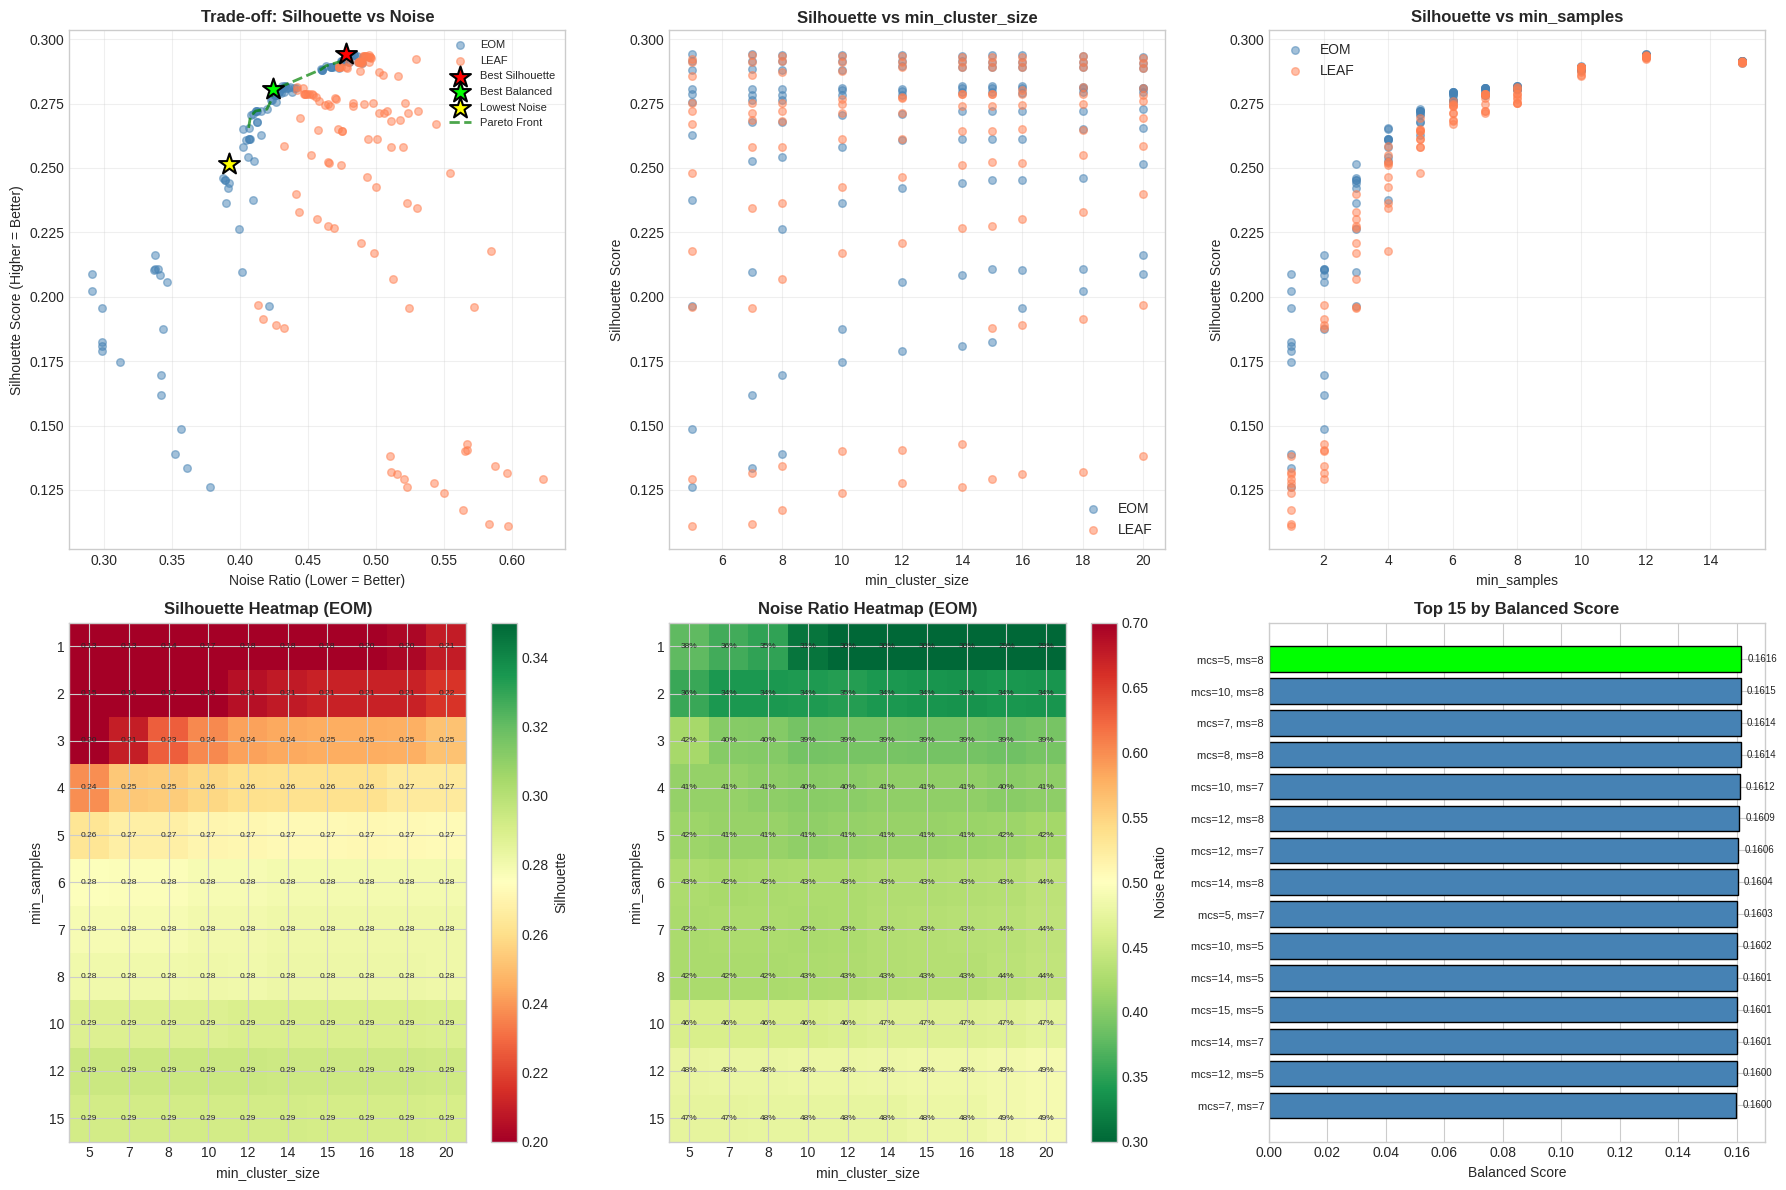

In [ ]:
# Analyze results from multiple perspectives
best_configs = analyze_results(granular_results)

# Generate visualizations
visualize_results(
    granular_results,
    best_configs,
    save_path=f"{Config.PLOTS_DIR}granular_hyperparameter_tuning.png"
)

In [ ]:
# Extract best configurations
best_sil = best_configs['best_silhouette']
best_bal = best_configs['best_balanced']
best_noise = best_configs['lowest_noise']

# Calculate cluster statistics for each best config
def get_cluster_stats(result):
    counts = result['cluster_counts']
    valid = {k: v for k, v in counts.items() if k != -1}
    sizes = list(valid.values()) if valid else [0]
    return {
        'n_clusters': len(valid),
        'min_size': min(sizes) if sizes else 0,
        'max_size': max(sizes) if sizes else 0,
        'mean_size': np.mean(sizes) if sizes else 0,
        'median_size': np.median(sizes) if sizes else 0
    }

sil_stats = get_cluster_stats(best_sil)
bal_stats = get_cluster_stats(best_bal)
noise_stats = get_cluster_stats(best_noise) if best_noise else None

print("\n" + "="*70)
print("📋 FINAL SUMMARY: GRANULAR HYPERPARAMETER TUNING")
print("="*70)

print(f"""
┌──────────────────────────────────────────────────────────────────────────┐
│                    GRANULAR TUNING RESULTS                               │
├──────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  Dataset: {embeddings.shape[0]:,} embeddings, {len(set([m['image_path'] for m in metadata])):,} unique photos                  │
│  Total configurations tested: {len(granular_results)}                                       │
│  Valid configurations: {len(best_configs['all_valid'])}                                            │
│                                                                          │
├──────────────────────────────────────���───────────────────────────────────┤
│  1️⃣  BEST SILHOUETTE                                                     │
│  ─────────────────────────────────────────────────────────────────────   │
│  Parameters: mcs={best_sil['min_cluster_size']}, ms={best_sil['min_samples']}, method={best_sil['cluster_selection_method']}                     │
│  Silhouette: {best_sil['silhouette']:.4f}    DBI: {best_sil['dbi']:.4f}                               │
│  Clusters: {best_sil['n_clusters']}    Noise: {best_sil['noise_ratio']:.1%} ({best_sil['n_noise']:,} points)                   │
│  Cluster sizes: {sil_stats['min_size']}-{sil_stats['max_size']} (mean: {sil_stats['mean_size']:.1f})                          │
│                                                                          │
├──────────────────────────────────────────────────────────────────────────┤
│  2️⃣  BEST BALANCED (Silhouette × Coverage)                               │
│  ─────────────────────────────────────────────────────────────────────   │
│  Parameters: mcs={best_bal['min_cluster_size']}, ms={best_bal['min_samples']}, method={best_bal['cluster_selection_method']}                     │
│  Silhouette: {best_bal['silhouette']:.4f}    DBI: {best_bal['dbi']:.4f}                               │
│  Clusters: {best_bal['n_clusters']}    Noise: {best_bal['noise_ratio']:.1%} ({best_bal['n_noise']:,} points)                   │
│  Balanced Score: {best_bal['balanced_score']:.4f}                                           │
│  Cluster sizes: {bal_stats['min_size']}-{bal_stats['max_size']} (mean: {bal_stats['mean_size']:.1f})                          │
│                                                                          │""")

if best_noise:
    print(f"""├──────────────────────────────────────────────────────────────────────────┤
│  3️⃣  LOWEST NOISE (Silhouette > 0.25)                                    │
│  ─────────────────────────────────────────────────────────────────────   │
│  Parameters: mcs={best_noise['min_cluster_size']}, ms={best_noise['min_samples']}, method={best_noise['cluster_selection_method']}                     │
│  Silhouette: {best_noise['silhouette']:.4f}    DBI: {best_noise['dbi']:.4f}                               │
│  Clusters: {best_noise['n_clusters']}    Noise: {best_noise['noise_ratio']:.1%} ({best_noise['n_noise']:,} points)                   │
│  Cluster sizes: {noise_stats['min_size']}-{noise_stats['max_size']} (mean: {noise_stats['mean_size']:.1f})                          │
│                                                                          │""")

print("""└──────────────────────────────────────────────────────────────────────────┘
""")

# Key insight
print("💡 KEY INSIGHT:")
print(f"   • Silhouette range: {min([r['silhouette'] for r in best_configs['all_valid']]):.4f} - {max([r['silhouette'] for r in best_configs['all_valid']]):.4f}")
print(f"   • Noise range: {min([r['noise_ratio'] for r in best_configs['all_valid']]):.1%} - {max([r['noise_ratio'] for r in best_configs['all_valid']]):.1%}")
print(f"   • Clear trade-off exists between cluster quality and data coverage")

# Save all results
save_data = {
    'timestamp': datetime.now().isoformat(),
    'dataset_info': {
        'n_embeddings': len(embeddings),
        'n_images': len(set([m['image_path'] for m in metadata])),
        'embedding_dim': embeddings.shape[1]
    },
    'param_grid': Config.PARAM_GRID,
    'all_results': granular_results,
    'best_configs': {
        'best_silhouette': {k: v for k, v in best_sil.items() if k != 'labels'},
        'best_balanced': {k: v for k, v in best_bal.items() if k != 'labels'},
        'lowest_noise': {k: v for k, v in best_noise.items() if k != 'labels'} if best_noise else None
    },
    'best_silhouette_labels': best_sil['labels'],
    'best_balanced_labels': best_bal['labels'],
    'lowest_noise_labels': best_noise['labels'] if best_noise else None,
    'pareto_optimal': [{k: v for k, v in r.items() if k not in ['labels', 'cluster_counts']}
                       for r in best_configs['pareto_optimal']]
}

save_path = f"{Config.RESULTS_DIR}granular_tuning_results.pkl"
with open(save_path, 'wb') as f:
    pickle.dump(save_data, f)

print(f"\n💾 Results saved: {save_path}")

# Next Steps
print("\n" + "="*70)
print("🎯 NEXT STEPS")
print("="*70)
print(f"""
   Pilih salah satu konfigurasi untuk eksperimen selanjutnya:

   • OPSI A (Best Silhouette): Fokus kualitas cluster
   • OPSI B (Best Balanced): Keseimbangan kualitas dan coverage
   • OPSI C (Lowest Noise): Maksimalkan data ter-cluster

   Kemudian:
   1. Bandingkan dengan QJSD metric (Experiment 1)
   2. Pilih Best_Metric (Euclidean atau QJSD)
   3. Lanjut ke CGA Noise Recovery (Experiment 2)
""")


📋 FINAL SUMMARY: GRANULAR HYPERPARAMETER TUNING

┌──────────────────────────────────────────────────────────────────────────┐
│                    GRANULAR TUNING RESULTS                               │
├──────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  Dataset: 12,715 embeddings, 2,365 unique photos                  │
│  Total configurations tested: 220                                       │
│  Valid configurations: 220                                            │
│                                                                          │
├──────────────────────────────────────���───────────────────────────────────┤
│  1️⃣  BEST SILHOUETTE                                                     │
│  ─────────────────────────────────────────────────────────────────────   │
│  Parameters: mcs=5, ms=12, method=eom                     │
│  Silhouette: 0.2943    DBI: 1.2592             